#**Important Equation**

$\mathbb{ln} q_j^* (Z_j) = \mathbb{E}_{i \ne j} [\mathbb{ln} p(X, Z)] + const $

#**Properties of factorized approximations**

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv, det
from tqdm.notebook import tqdm
import random
from scipy.stats import multivariate_normal

0.5004852648986244
0.5003639486739684
0.5249999999999999
0.5249999999999999
0.5
0.5
1.2
1.2


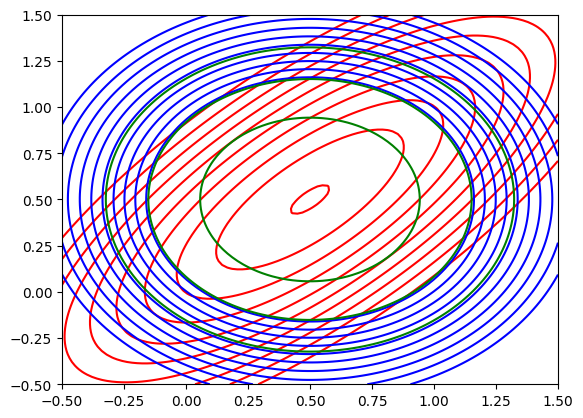

In [96]:
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)

# mu = np.array([[0.5], [0.5]])
mu = np.array([0.5, 0.5])
sigma = np.array([[1.2, 0.9], [0.9, 1.2]])
z1 = np.linspace(-0.5, 1.5, 100)
z2 = np.linspace(-0.5, 1.5, 100)
z1, z2 = np.meshgrid(z1, z2)
x = np.concatenate((z1[:, :, np.newaxis], z2[:, :, np.newaxis]), axis = 2)
prob = multivariate_normal.pdf(x, mu, sigma)
plt.contour(z1, z2, prob, np.linspace(0.1, 0.2, 10), colors = "r")


# Maximize Lower Bound (Equivilent to minimizing KL Divergence q|p)
precision = inv(sigma)
m1 = np.random.uniform(0, 1)
m2 = np.random.uniform(0, 1)
sigma1 = 1 / precision[0][0]
sigma2 = 1 / precision[1][1]
iters = 10
for iter in range(0, iters):
  m1 = mu[0] - 1 / precision[0][0] * precision[0][1] * (m2 - mu[1])
  m2 = mu[1] - 1 / precision[1][1] * precision[1][0] * (m1 - mu[0])

prob = multivariate_normal.pdf(x, [m1, m2], [[sigma1, 0], [0, sigma2]])
plt.contour(z1, z2, prob, np.linspace(0.1, 0.2, 10), colors = "b")
print(m1)
print(m2)
print(sigma1)
print(sigma2)


# Minimizing Reverse KL Divergence p|q)
m1 = mu[0]
m2 = mu[1]
sigma1 = sigma[0][0]
sigma2 = sigma[1][1]
prob = multivariate_normal.pdf(x, [m1, m2], [[sigma1, 0], [0, sigma2]])
# [0.17, 0.18, 0.19, 0.2]
plt.contour(z1, z2, prob, np.linspace(0.1, 0.2, 10), colors = "g")
print(m1)
print(m2)
print(sigma1)
print(sigma2)

# Both got the correct mean.
# KL divergence q|p has a smaller variance
# Reverse KL divergence p|q has a bigger variance

#**Variational Mixture of Gaussians**

(200, 2)


<ipython-input-3-15ea7ac3d2da>:11: RuntimeWarning: covariance is not positive-semidefinite.
  x_train = np.concatenate((x_train, np.random.multivariate_normal(mean2, cov2, size2)), axis=0)


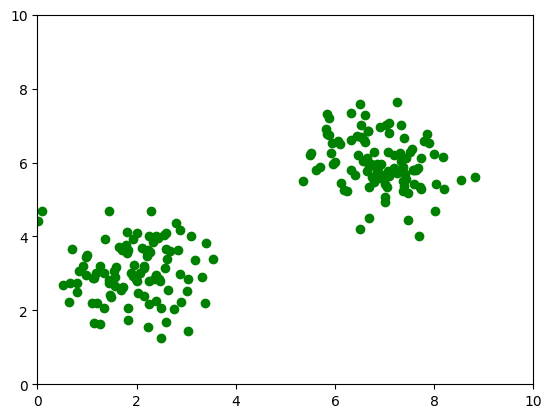

In [3]:
mean1 = np.array([2, 3])
mean2 = np.array([7, 6])
cov1 = np.array([[0.6, 0.0], [0.0, 0.6]])
cov2 = np.array([[0.6, -0.30], [-0.0, 0.6]])
size1 = 100
size2 = 100
train_size = size1 + size2

# N * 2
x_train = np.random.multivariate_normal(mean1, cov1, size1)
x_train = np.concatenate((x_train, np.random.multivariate_normal(mean2, cov2, size2)), axis=0)
print(x_train.shape)

plt.xlim(0, 10)
plt.ylim(0, 10)
plt.scatter(x_train[:, 0], x_train[:, 1], c="g")


In [30]:
from scipy.stats import wishart
K = 6
N = train_size
D = 2


alpha = np.ones((K, )) * 0.1
def SamplePi():
  return np.random.dirichlet(alpha, 1)

m = np.random.random((K, 2))
beta = np.ones((K, ))
W = np.tile(np.eye(2), (K, 1, 1))
v = np.ones((K, )) + 1
def SamplePrecision():
  res = []
  for k in range(0, K):
    res.append(wishart.rvs(v[k], W[k], 1))
  return np.array(res)
def SampleMu(precision):
  res = []
  for k in range(0, K):
    res.append(np.random.multivariate_normal(m[k], inv(beta[k] * precision[k])))
  return np.array(res)

alpha_0 = np.copy(alpha)
# m_0 = np.copy(m)
# beta_0 = np.copy(beta)
# W_0 = np.copy(W)
# v_0 = np.copy(v)

In [ ]:
print(SamplePi())
precision = SamplePrecision()
print(precision)
print(SampleMu(precision))

In [31]:
from scipy.special import digamma

# E step
def calc_r():
  # 10.64
  E0 = np.zeros((N, K))
  for n in range(0, N):
    for k in range(0, K):
      difference = (x_train[n] - m[k])[:, np.newaxis] # 2 * 1
      E0[n][k] = D / beta[k] + v[k] * difference.T @ W[k] @ difference

  # 10.65
  E1 = np.zeros(K)
  for k in range(0, K):
    for i in range(0, D):
      E1[k] += digamma((v[k] + 1 - i) / 2)
    E1[k] += D * np.log(2) + np.log(det(W[k]))

  # 10.66
  E2 = np.zeros(K)
  for k in range(0, K):
    E2[k] = digamma(alpha[k]) - digamma(alpha.sum())

  # 10.46
  ln_rho = np.zeros((N, K))
  for n in range(0, N):
    for k in range(0, K):
      ln_rho[n][k] = E2[k] + 1/2 * E1[k]  - D / 2 * np.log(2 * np.pi) - 1/2 * E0[n][k]

  # print(E0)
  # print(E1)
  # print(E2)


  # print(ln_rho)
  rho = np.exp(ln_rho)
  # print(rho)

  # 10.49
  sum_rho = rho.sum(1, keepdims=True)
  r = rho / sum_rho

  return r
print(calc_r())

[[1.76352684e-01 1.21832877e-01 1.26906295e-01 1.37145206e-01
  5.72892038e-02 3.80473735e-01]
 [1.37000859e-01 9.26960155e-02 7.55628584e-02 9.42470345e-02
  2.02756494e-02 5.80217584e-01]
 [1.17506568e-01 1.54270044e-01 5.77511698e-02 1.10040631e-01
  8.67833905e-03 5.51753249e-01]
 ...
 [1.14413287e-02 8.23348809e-01 2.89454282e-03 6.99787651e-02
  1.39897390e-05 9.23225651e-02]
 [1.16821457e-02 8.15577639e-01 2.89503899e-03 6.96898753e-02
  1.36429168e-05 1.00141658e-01]
 [6.27607439e-03 8.70916405e-01 1.28618710e-03 5.00413707e-02
  2.88726758e-06 7.14770754e-02]]


In [32]:
# M step
def calc_beta_m_W_v(r):
  # 10.51
  N_k = np.zeros((K,))
  for k in range(0, K):
    N_k[k] = r[:, k].sum()

  # 10.52
  x_mean = np.zeros((K, 2))
  for k in range(0, K):
    for n in range(0, N):
      x_mean[k] += r[n][k] * x_train[n]
    x_mean[k] = x_mean[k] / N_k[k]

  # 10.53
  S = np.zeros((K, 2, 2))
  for k in range(0, K):
    for n in range(0, N):
      difference = (x_train[n] - x_mean[k])[:, np.newaxis]  # 2 * 1
      S[k] += r[n][k] * difference @ difference.T
    S[k] = S[k] / N_k[k]

  # print(N_k.shape)
  # print(x_mean.shape)
  # print(S.shape)

  # 10.58
  alpha_new = alpha + N_k
  # print(x_mean.shape)

  #10.60
  beta_new = beta + N_k
  # print(beta_new.shape)

  #10.61
  m_new = 1 / beta_new[:, np.newaxis] * (beta[:, np.newaxis] * m + N_k[:, np.newaxis] * x_mean)
  # print(m_new.shape)

  #10.62
  W_new = np.zeros((K, 2, 2))
  for k in range(0, K):
    difference = (x_mean[k] - m[k])[:, np.newaxis]
    inv_W_new = inv(W[k]) + N_k[k] * S[k] + beta[k] * N_k[k] / (beta[k] + N_k[k]) * difference @ difference.T
    W_new[k] = inv(inv_W_new)

  #10.63
  v_new = v + N_k

  # 10.69
  Expectation_pi = (alpha_0 + N_k) / (K * alpha_0 + N)

  return N_k, x_mean, S, alpha_new, beta_new, m_new, W_new, v_new, Expectation_pi

In [33]:
iters = 100
for iter in range(0, iters):
  # E step
  r = calc_r()
  # M step
  N_k, x_mean, S, alpha_new, beta_new, m_new, W_new, v_new, Expectation_pi = calc_beta_m_W_v(r)
  alpha = alpha_new
  beta = beta_new
  m = m_new
  W = W_new
  v = v_new

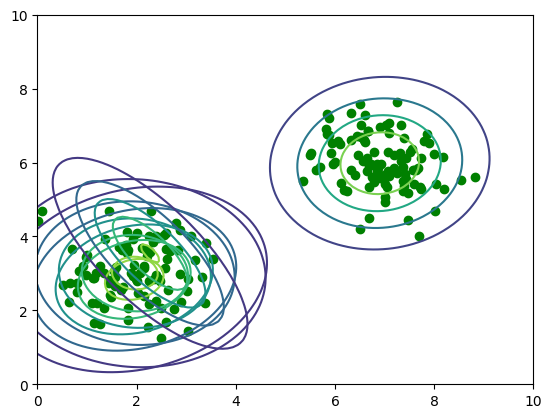

In [39]:
def plot_distribution(mean, cov):
  x, y = np.meshgrid(np.linspace(0, 10, 100), np.linspace(0, 10, 100))
  xy = np.column_stack([x.ravel(), y.ravel()])
  mvn = multivariate_normal(mean, cov)
  z = mvn.pdf(xy).reshape(x.shape)
  plt.contour(x, y, z, levels=5, cmap='viridis')

plt.xlim(0, 10)
plt.ylim(0, 10)
plt.scatter(x_train[:, 0], x_train[:, 1], c="g")
for k in range(0, K):
  if Expectation_pi[k] < 0.1:
    continue
  # expectation of gaussian and Wishart
  plot_distribution(m[k], v[k] * W[k])

#**Variational Linear Regression**

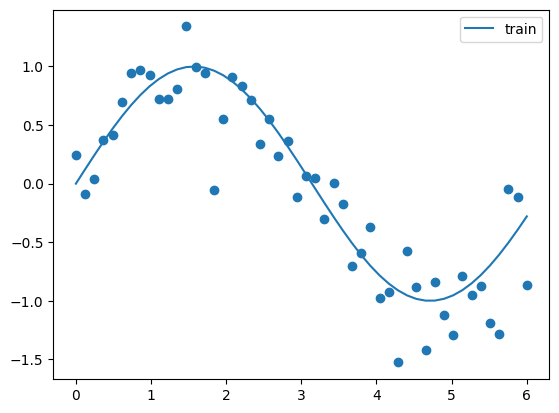

In [30]:
def func(x):
  return np.sin(x)

def plotFunc():
  x = np.linspace(0, 6, 50)
  y = func(x)
  plt.plot(x, y, label = "train")

plotFunc()
train_size = 50
x_train = np.linspace(0, 6, train_size)
y_train = func(x_train) + np.random.normal(0, 0.3, (train_size,))
plt.scatter(x_train, y_train)
plt.legend()

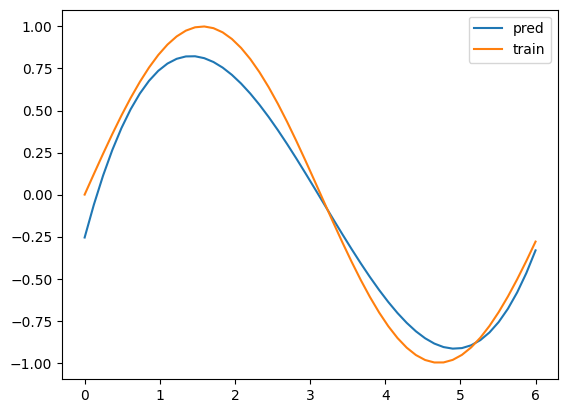

In [18]:
N = train_size
M = 4

beta = 1 / 0.09

m = np.random.random((M, 1))
S = np.eye(M)
a = np.random.random()
b = np.random.random()
phi = np.concatenate([x_train[:, np.newaxis]**m for m in range(0, M)], axis=1)

iters = 10
for iter in range(0, iters):
  # 10.94
  a = a + M / 2
  # 10.95
  b = b + 1/2 * (m.T @ m + np.trace(S)) # expectation of W^T W

  # 10.101
  S = inv(np.eye(M) * M / (m.T @ m + np.trace(S)) + beta * phi.T @ phi) # 10.104
  # 10.100
  m = beta * S @ phi.T @ y_train[:, np.newaxis]

x_test = np.linspace(0, 6, 50)
phi_test = np.concatenate([x_test[:, np.newaxis]**m for m in range(0, M)], axis=1)
pred = phi_test @ m
plt.plot(x_test, pred, label = "pred")
plotFunc()
plt.legend()

#**Local Variational Methods**

$λ(ξ) = -\frac{1}{4ξ} tanh(\frac{ξ}{2}) = -\frac{1}{2ξ}[σ(ξ) - \frac{1}{2}]$

$σ(x) \ge σ(ξ) {exp (x - ξ)/2 - λ(ξ)(x^2 - ξ^2)}$

#**Variational Logistic Regression**

$q(w) = \mathcal{N} (w|m_N , S_N ) $

E step:

$m_N = S_N\{S^{-1}_0 m_0 + \sum_{n=1}^{N}(t_n - \frac{1}{2})\phi_n\}$

$S^{-1}_N = S^{-1}_0 + 2\sum_{n=1}^{N}λ(ξ_n)\phi_n \phi_n^T$

\
M step:

(Take the derivative of the expectation of the complete data likelihood)

$(ξ^{new}_n )^2 = \phi_n^T E[ww^T]\phi_n = \phi_n^T (S_N + m_N m^T_N) \phi_n$

#*Consider hyperparameter $\alpha$*

As we replaced $p(t|w)$ with $h$, $\beta$ no longer appears.

Suppose $p(\alpha) = Gam(a_0, b_0)$

Use variational method to take the expectation of complete data likelihood with repect to $\alpha$ and $w$ to get:


$w$ (take $\mathbb{E}_\alpha$):

* $\mu_N = S_N\sum_{n=1}^{N}(t_n - \frac{1}{2})\phi_n$

* $\Sigma_N^{-1} = \mathbb{E}[\alpha] \mathbf{I} + 2\sum_{n=1}^{N}λ(ξ_n)\phi_n \phi_n^T$

$\alpha$ (take $\mathbb{E}_w$):

* $a_N = a_0 + \frac{M}{2}$

* $b_N = b_0 + \frac{1}{2}\mathbb{E}[w^Tw]$

\
For variational parameter $\xi$, we take the derivative of the lower bound to get:

$(ξ^{new}_n )^2 = \phi_n^T (\Sigma_N + \mu_N \mu_N^T) \phi_n$

<ipython-input-34-ae177c31edf1>:18: RuntimeWarning: divide by zero encountered in divide
  lambda_ = -1/(2 * xi) * (sigmoid(xi) - 1/2)
<ipython-input-34-ae177c31edf1>:18: RuntimeWarning: invalid value encountered in multiply
  lambda_ = -1/(2 * xi) * (sigmoid(xi) - 1/2)


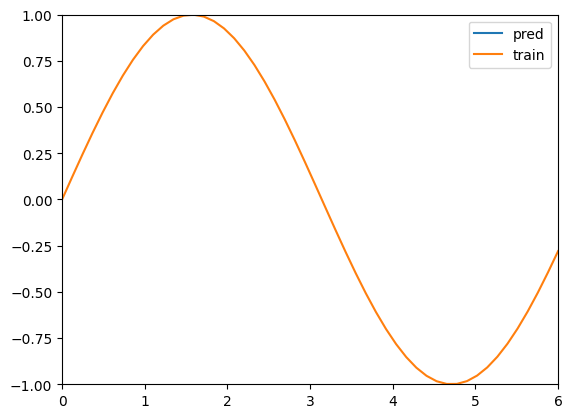

In [34]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

N = train_size
M = 4

xi = np.random.random((N,))

mu = np.random.random((M, 1))
Sigma = np.eye(M)
a = np.random.random()
b = np.random.random()
phi = np.concatenate([x_train[:, np.newaxis]**m for m in range(0, M)], axis=1)

iters = 10
for iter in range(0, iters):
  # 10.175
  lambda_ = -1/(2 * xi) * (sigmoid(xi) - 1/2)
  phi_phiT = np.einsum('ij,ik->ijk', phi, phi)  # 100 * 4  =>  100 * 4 * 4    100 phi @ phi.T
  Sigma = inv(np.eye(M) * (a/b) + 2 * (lambda_[:, np.newaxis, np.newaxis] * phi_phiT).sum(axis=0)) # 10.104
  # 10.176
  mu = Sigma @ ((y_train[:, np.newaxis] - 1/2) * phi).sum(axis=0)[:, np.newaxis]

  # Exactly the same
  # 10.178
  a = a + M / 2
  # 10.179
  b = b + 1/2 * (mu.T @ mu + np.trace(Sigma))

  # 10.181
  for i in range(0, N):
    phi_n = phi[i][:, np.newaxis]
    xi[i] = phi_n.T @ (Sigma + mu @ mu.T) @ phi_n

plt.xlim(0, 6)
plt.ylim(-1, 1)
x_test = np.linspace(0, 6, 50)
phi_test = np.concatenate([x_test[:, np.newaxis]**m for m in range(0, M)], axis=1)
pred = phi_test @ mu
plt.plot(x_test, pred, label = "pred")
plotFunc()
plt.legend()

#**Expectation propogation**

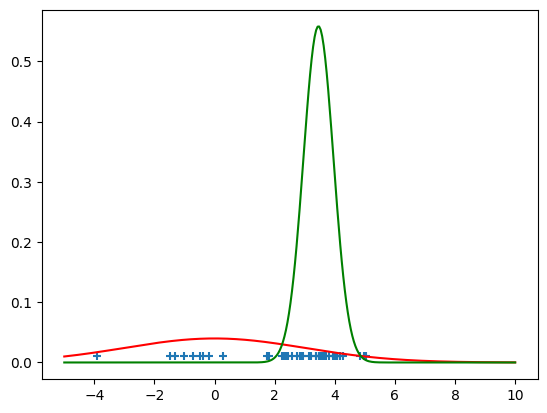

In [51]:
background_mean = 0
background_variance = 3
background_ratio = 0.3

target_mean = 3.456
target_variance = 0.5

from scipy.stats import norm
x = np.linspace(-5, 10, 300)
background_pdf = background_ratio * norm.pdf(x, background_mean, background_variance)
target_pdf = (1-background_ratio) * norm.pdf(x, target_mean, target_variance)
plt.plot(x, background_pdf, c = "r")
plt.plot(x, target_pdf, c = "g")

x_train = []
train_size = 50
for i in range(0, train_size):
  if np.random.random() < background_ratio:
    x_train.append(np.random.normal(background_mean, background_variance**0.5, 1))
  else:
    x_train.append(np.random.normal(target_mean, target_variance**0.5, 1))

plt.scatter(x_train, np.ones_like(x_train) * 0.01, marker='+')

<ipython-input-67-5b26019f197d>:28: RuntimeWarning: invalid value encountered in double_scalars
  s[n] = Z_n / ((2 * np.pi * v[n]) ** (1/2) * norm.pdf(m[n], m_exclude_n, v[n] + v_exclude_n))


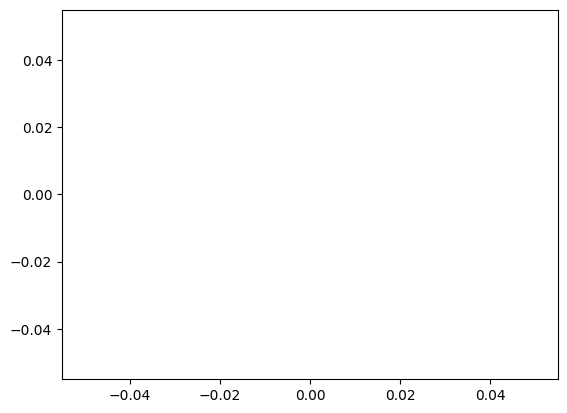

In [67]:
a = 10
b = 100
w = 0.5

M = np.random.random()
V = np.random.random()

m = np.random.random((N, ))
v = np.random.random((N, ))
s = np.random.random((N, ))

iters = 10
for iter in range(iters):
  for n in range(0, N):
    # 10.215, 10.214, 10.216
    v_exclude_n = 1 / (1/V - 1/v[n])
    m_exclude_n = M + v_exclude_n * 1/v[n] * (M - m[n])
    Z_n = (1 - w) * norm.pdf(x_train[n], m_exclude_n, v_exclude_n + 1) + w * norm.pdf(x_train[n], 0, a)

    # 10.219, 10.217, 10.218
    rho_n = 1 - w/Z_n * norm.pdf(x_train[n], 0, a)
    M = m_exclude_n + rho_n * v_exclude_n / (1 + v_exclude_n) * (x_train[n] - m_exclude_n)
    V = v_exclude_n - rho_n * v_exclude_n**2 / (1 + v_exclude_n) + rho_n * (1 - rho_n) * v_exclude_n**2 * ((x_train[n] - m_exclude_n)**2).sum() / (1 * (v_exclude_n + 1)**2)

    # 10.220, 10.221, 10.222
    v[n] = 1 / (1/V - 1/v_exclude_n)
    m[n] = m_exclude_n + (v[n] + v_exclude_n) * 1/(v_exclude_n) * (M - m_exclude_n)
    s[n] = Z_n / ((2 * np.pi * v[n]) ** (1/2) * norm.pdf(m[n], m_exclude_n, v[n] + v_exclude_n))

x = np.linspace(-5, 10, 300)
pred_pdf = norm.pdf(x, M, V)
plt.plot(x, pred_pdf, c = "g")

In [68]:
print(M)
print(V)

[nan]
[nan]
